In [1]:
import re
import pandas as pd
import numpy as np
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# globals
stop = stopwords.words('english')

## Load data and clean

In [2]:
df = pd.read_json('../data/craigslist_music_scraped.json')
df.shape

(24998, 9)

In [3]:
# de-duplicate exact raw posts
df = df.loc[~df.duplicated(subset=['body'], keep='first')]
df.shape

(19920, 9)

In [4]:
def dup_clean(s):
    if type(s) != str:
        return ""
    no_qr = re.sub("QR Code Link to This Post", '', s).lower().strip()
    return no_qr

In [5]:
# modify text body to lowercase, remove QR tag and strip
df.body = df.body.apply(dup_clean)
# de-duplicate exact processed posts
df = df.loc[~df.duplicated(subset=['body'], keep='first')]
# combine title and body
df['body'] = df.title + ' \n' + df.body
df.shape

(19506, 9)

In [6]:
def prep_body_keepnum(s):
    if type(s) != str:
        return ""
    no_https = re.sub("https?://[^\s]+", '', s)
    no_http = re.sub("http?://[^\s]+", '', no_https)
    no_www = re.sub("www?[^\s]+", '', no_http)
    words = TextBlob(no_www).words
    words = [w for w in words if w not in stop]
    prep_body = ' '.join(words)
    return prep_body

def prep_body(s):
    if type(s) != str:
        return ""
    no_https = re.sub("https?://[^\s]+", '', s)
    no_http = re.sub("http?://[^\s]+", '', no_https)
    no_www = re.sub("www?[^\s]+", '', no_http)
    body = re.sub("[0-9]",'',no_www).strip()
    words = TextBlob(body).words
    words = [w for w in words if w not in stop]
    prep_body = ' '.join(words)
    return prep_body

def compress(iterables):
    outer = []
    for it in iterables:
        if type(it) != list:
            outer.append(it)
        else:
            outer += it
    return Counter(outer)

def extract_genres(s):
    genre_r = []
    for genre in genres:
        if genre in s:
            genre_r.append(genre_map[genre])
    return compress(genre_r)

def extract_instruments(s):
    instr_r = []
    for instrument in instrument_types:
        if instrument in s:
            instr_r.append(instruments[instrument])
    return compress(instr_r)

In [7]:
df["prep_body_keepnum"] = df["body"].apply(prep_body_keepnum)
df["prep_body"] = df["body"].apply(prep_body)
df["body_len"] = df["prep_body"].apply(lambda x: len(x))

## Stemming

In [8]:
def stem_text(body):
    words = TextBlob(body).words
    stemmer = PorterStemmer()
    stems = [stemmer.stem(word) for word in words]
    stemmed = ' '.join(stems)
    return stemmed

In [9]:
df["prep_body"] = df["prep_body"].apply(str)
df["prep_body_keepnum"] = df["prep_body_keepnum"].apply(str)
df["prep_body"] = df["prep_body"].apply(stem_text)
df["prep_body_keepnum"] = df["prep_body_keepnum"].apply(stem_text)

## De-duplicate based on cosine similarity

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [11]:
posts = df.prep_body.values.tolist()
vectorizer = CountVectorizer()
count_vec = vectorizer.fit_transform(posts)

In [12]:
count_vec.shape

(19506, 33181)

In [13]:
threshold = 0.98
kill = set()
for i in range(count_vec.shape[0]):
    cosine_similarities = cosine_similarity(count_vec[i:i+1], count_vec).flatten()
    indices = np.where(cosine_similarities > threshold)[0]
    indices = indices[np.where(indices > i)]
    for kill_index in indices:
        kill.add(kill_index)

In [14]:
len(kill)

1140

In [15]:
df.shape

(19506, 12)

In [22]:
df_dedup = df.drop(df.index[list(kill)])

In [23]:
df_dedup.shape

(18366, 12)

## Get genre / instrument categories

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
from mappings.genre_map import genre_map
from mappings.instruments import instruments
# globals
genres = genre_map.keys()
instrument_types = instruments.keys()

In [25]:
df["genre_counts"] = df["prep_body"].apply(extract_genres)
df["instrument_counts"] = df["prep_body"].apply(extract_instruments)

In [27]:
genre_counts = pd.DataFrame(df["genre_counts"].tolist()).fillna(0)
instr_counts = pd.DataFrame(df["instrument_counts"].tolist()).fillna(0)
df = pd.concat([df, genre_counts, instr_counts], axis=1)

In [28]:
df.head()

,body,captured,city,gmap_acc,gmap_lat,gmap_lon,index,title,url,prep_body_keepnum,...,rock,bass,dj,drums,guitar,horns,keys,percussion,strings,vocalist
0,VOICE Lessons & the ART of SINGING Beginners ...,2017-11-01 14:20:56,new york,22.0,40.77630,-73.911000,0.0,VOICE Lessons & the ART of SINGING Beginners ...,https://newyork.craigslist.org/que/muc/d/voice...,voic lesson art sing beginn welcom classic voi...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Guitar lessons- Queen Anne/Belltown/Downtown \...,2017-11-01 14:20:56,seattle,15.0,47.61872,-122.356738,1.0,Guitar lessons- Queen Anne/Belltown/Downtown,https://seattle.craigslist.org/see/muc/d/guita...,guitar lesson queen anne/belltown/downtown hel...,...,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Record and Mix \nengineer with studio for arti...,2017-11-01 14:20:56,boston,NaN,NaN,NaN,2.0,Record and Mix,https://boston.craigslist.org/gbs/muc/d/record...,record mix engin studio artist band group reco...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,GUITAR LESSONS BY EXPERIENCED PROFESSIONAL GUI...,2017-11-01 14:20:56,new york,NaN,NaN,NaN,3.0,GUITAR LESSONS BY EXPERIENCED PROFESSIONAL GUI...,https://newyork.craigslist.org/brk/muc/d/guita...,guitar lesson BY experienc profession guitaris...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Professional Guitarist available for gigs \nhi...,2017-11-01 14:20:56,new york,NaN,NaN,NaN,4.0,Professional Guitarist available for gigs,https://newyork.craigslist.org/mnh/muc/d/profe...,profession guitarist avail gig hi need guitari...,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


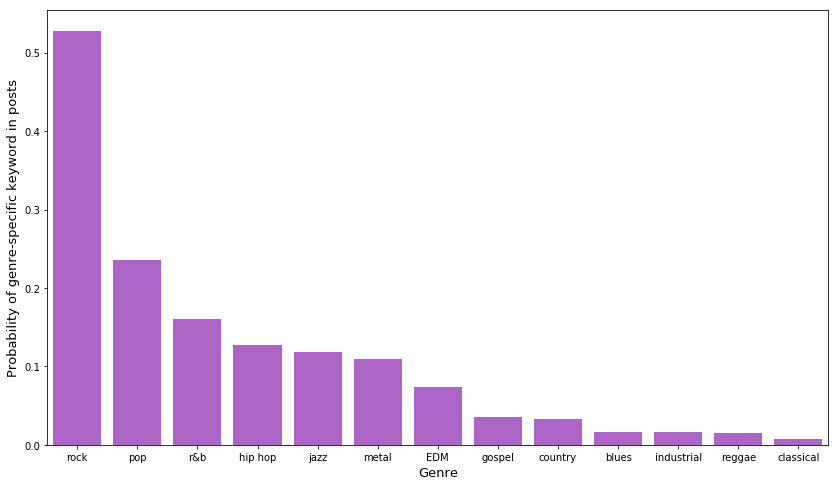

In [39]:
plt.figure(figsize=(14,8))
genrebarchart = sns.barplot(x='index', y='mean', data=df[genre_counts.columns].describe().loc['mean'].reset_index().sort_values('mean', ascending=False),color='#b355d6')
genrebarchart.set_ylabel('Probability of genre-specific keyword in posts',fontdict={'size':13})
genrebarchart.set_xlabel('Genre',fontdict={'size':13})

In [30]:
df[instr_counts.columns].describe()

,bass,dj,drums,guitar,horns,keys,percussion,strings,vocalist
count,19506.000000,19506.000000,19506.000000,19506.000000,19506.000000,19506.000000,19506.000000,19506.000000,19506.000000
mean,0.171383,0.034861,0.202963,0.384753,0.072952,0.205168,0.017738,0.042756,0.316159
std,0.414556,0.184269,0.402216,0.486549,0.416968,0.501059,0.146017,0.239235,0.560022
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.000000,2.000000,1.000000,1.000000,12.000000,5.000000,3.000000,3.000000,3.000000
